In [1]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json
import time
from astropy.time import Time
from mpl_toolkits import mplot3d

plt.rcParams.update({'font.size': 12})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'



/home/jtb34/GitHub/GACF/NGTS/NGTS_Field.py:11: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")
/home/jtb34/GitHub/GACF/NGTS/GACF_utils/ngtsio_utils.py:10: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")


In [2]:
XMATCH_LOCATION = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(field):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(field.fieldname),
                               XMATCH_FILE_NAME.format(field.fieldname))
    if not os.path.exists(xmatch_path):
        print xmatch_path, 'does not exist'
        return field

    with fits.open(xmatch_path) as gfits:
        for i, obj in enumerate(gfits[1].data['Sequence_number']):
            if obj in field.objects:
                field[obj].Gaia_Teff = gfits[1].data['Gaia_Teff'][i]
                field[obj].Gaia_Radius = gfits[1].data['Gaia_Radius'][i]
                field[obj].Gaia_Lum = gfits[1].data['Gaia_Lum'][i]
                field[obj].Gaia_Parallax = gfits[1].data['Gaia_Parallax'][i]
                field[obj].TWOMASS_Hmag = gfits[1].data['2MASS_Hmag'][i]
                field[obj].TWOMASS_Kmag = gfits[1].data['2MASS_Kmag'][i]
                field[obj].APASS_Vmag = gfits[1].data['APASS_Vmag'][i]
                field[obj].APASS_Bmag = gfits[1].data['APASS_Bmag'][i]
                field[obj].Gaia_Gmag = gfits[1].data['Gaia_Gmag'][i]
                field[obj].Gaia_RPmag = gfits[1].data['Gaia_RPmag'][i]
                field[obj].Gaia_BPmag = gfits[1].data['Gaia_BPmag'][i]
                field[obj].NGTS_I_3 = gfits[1].data['NGTS_I_3'][i]
                field[obj].BminusV = field[obj].APASS_Bmag - field[obj].APASS_Vmag
                field[obj].HminusK = field[obj].TWOMASS_Hmag - field[obj].TWOMASS_Kmag
                field[obj].GminusK = field[obj].Gaia_Gmag - field[obj].TWOMASS_Kmag
                field[obj].BPminusRP = field[obj].Gaia_BPmag - field[obj].Gaia_RPmag
#         print gfits[1].header

    return field

In [3]:
def find_fits_file(directory=None):
    if directory is None:
         directory = os.getcwd()
    string_pattern = r'^(?P<fieldname>\w+?[+-]\w+?)_\d+_[\w\-/,]+_(?P<test>\w+).fits$'
    pattern = re.compile(string_pattern)
    for f in os.listdir(directory):
        match = re.match(pattern, f)
        if match is not None:
            return f if directory is None else os.path.join(directory, f), match.group('fieldname'), match.group('test')
        
    raise IOError('File not found in directory {}'.format(directory))
    
# field.load_from_fits(fits_file, obj_ids=object_list, method='fitsio')

In [4]:
def split_phase(phase, data, timeseries=None, buff=0.9, nperiods=1):
    # returns list of lists of data & phases for complete periods (requires sorted phased timeseries)
    # buff => require this much phase coverage in first and last segments
    phases = []
    datas = []
    timeseriess = [] if timeseries is not None else None
    
    idx_changes = np.where(np.diff(phase) < 0)[0][::nperiods]
    use_first = True if (phase[0] < 1.0 - buff) else False
    use_last = True if (phase[-1] > buff) else False

    if use_first:
        phases.append(phase[:idx_changes[0]])
        datas.append(data[:idx_changes[0]])
        if timeseriess is not None:
            timeseriess.append(timeseries[:idx_changes[0]])
        
    for i, idx in enumerate(idx_changes[:-1]):
        phases.append(phase[idx+1:idx_changes[i+1]])
        datas.append(data[idx+1:idx_changes[i+1]])
        if timeseriess is not None:
            timeseriess.append(timeseries[idx+1:idx_changes[i+1]])
        
    if use_last or np.any(np.diff(phase[idx_changes[-1]+1:]) < 0):
        phases.append(phase[idx_changes[-1]:])
        datas.append(data[idx_changes[-1]:])
        if timeseriess is not None:
            timeseriess.append(timeseries[idx_changes[-1]:])
    if timeseriess is not None:    
        return phases, datas, timeseriess
    else:
        return phases, datas
#     save = False
#     phase_count = 0
#     for p, d in zip(phase, data):
        

In [10]:
pdics = {}
fieldnames = []
field_pattern = re.compile(r'^NG\d+[+|-]\d+$')

for f in os.listdir(ROOT_DIR):
    if re.match(field_pattern, f):
        fieldnames.append(f)
print "Found {} fields".format(len(fieldnames))
# print fieldnames
# fieldnames = fieldnames[1:5]
# fieldnames = ['NG2346-3633']

for field in fieldnames:
    field_dir = os.path.join(ROOT_DIR, field)
    pdic_filename = 'NGTS_Field_{}_pdic.json'.format(field)
    if pdic_filename in os.listdir(field_dir):
        with open(os.path.join(*[ROOT_DIR, field, pdic_filename])) as f:
            pdics[field] = json.load(f)
            pdics[field] = {int(k):v for k,v in pdics[field].iteritems()}

Found 115 fields


In [11]:
FIELDNAME = 'NG0304-1115'
fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, FIELDNAME))
with fits.open(fits_file) as ff:
    obj_ids = np.array(map(int, ff['CATALOGUE'].data['OBJ_ID']))
print '{} objects found'.format(len(obj_ids))

3341 objects found


In [12]:
# first_obj = np.random.randint(0, len(obj_ids)-1)
# long_periods = {FIELDNAME: list(obj_ids[np.arange(first_obj, min(first_obj + 100, len(obj_ids)-1), 1)])}
long_periods = {FIELDNAME: pdics[FIELDNAME].keys()}
print long_periods

{'NG0304-1115': [14338, 8196, 12304, 2734, 8215, 14364, 12317, 16423, 18474, 2091, 18481, 2098, 8247, 8260, 12357, 14411, 16462, 12367, 2744, 10323, 85, 12389, 102, 12394, 16491, 2160, 16500, 118, 18551, 4216, 12415, 6273, 10375, 6286, 4241, 4248, 6299, 12461, 175, 14512, 14516, 16570, 8379, 6332, 8906, 192, 8386, 4294, 15735, 12496, 8402, 14551, 4315, 16609, 4327, 4329, 6379, 4333, 8433, 18687, 10496, 14379, 16645, 2311, 12556, 272, 12564, 4373, 291, 18725, 18728, 8490, 14636, 14645, 10559, 12609, 337, 10581, 12630, 14700, 16752, 4475, 18814, 6542, 2447, 8601, 10650, 8603, 6557, 18849, 18867, 10684, 18885, 4559, 18901, 10711, 6617, 8671, 14821, 18918, 16877, 8693, 2550, 10768, 18963, 4628, 2604, 10808, 16964, 2630, 4683, 8780, 10838, 8802, 16995, 19047, 624, 12913, 4728, 2683, 8299, 17343, 17034, 10891, 8858, 19099, 14448, 17067, 6830, 19121, 6835, 8888, 19131, 8896, 4803, 19141, 710, 6857, 714, 6876, 19167, 4843, 1490, 13040, 19187, 13049, 17149, 7637, 13068, 19217, 15125, 15132, 110

In [13]:
import NGTS.NGTS_Field as NGTS_Field

reload(NGTS_Field)

fields = {}
# gfields = {}
good_objs = 0
ratios = []
for fieldname, objs in long_periods.iteritems():
    if len(objs) < 1:
        continue
#     objs = np.array(objs)[np.random.randint(0, len(objs)-1, 10)].tolist()
#     if fieldname not in ['NG0409-1941']:
#         continue
# for fieldname, objs in {'NG0004-2950': [2048]}.iteritems():
    t1 = time.time()
    field = NGTS_Field.return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', 
                                               include_empty_objects=True, silent=True, obj_ids=objs[:10])
#     field = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=pdics[fieldname].keys())
#     t2 = time.time()
#     field = load_gaia_params(field)
#     t3 = time.time()
#     for obj in field:
#         try:
#             obj.cleaned_refined_periods = pdics[fieldname][obj.obj]
#         except KeyError:
#             obj.cleaned_refined_periods = None
    
#     gfield = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=obj_lists[fieldname])
#     gfield = load_gaia_params(gfield)
    t4 = time.time()
    fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, fieldname))
    field.load_from_fits(fits_file, obj_ids=objs, method='fitsio', sparse_ids=True)
    t5 = time.time()
#     new_moon_epoch = field.get_new_moon_epoch()
    fields[fieldname] = field
    print 'Field {} loaded'.format(field)

matched 3341 of 3490 files. Loaded 10 objects


KeyError: 18481

In [14]:
new_moon_epoch = 739.1143560680686

In [ ]:
ratios = []
for fieldname, field in fields.iteritems():
    n = 0
    for obj in field:
#         if obj.obj not in cool_objs:
#             continue
#         if n < 5:
#             n += 1
#             continue
#         if n > 10:
#             break
#         print '****** {} ******'.format(obj)
#         print obj.periods
#         print obj.cleaned_refined_periods
#         print obj.peak_size
        obj.nsig2keep = 5
        
        t = obj.timeseries_binned
        f = obj.flux_binned
#         p = pdics[fieldname][obj.obj][0]
        try:
            p = obj.periods[0]
            if p < 1.0:
#                 field.objects[obj.obj] = None
                continue
#             if len(obj.periods > 10):
#                 field.objects[obj.obj] = None
#                 continue
        except Exception:
#             field.objects[obj.obj] = None
            continue
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        tref = (Time(Time(np.median(t) + utils.NGTS_EPOCH, format='jd').to_datetime()
                     .replace(hour=12, minute=0, second=0)).jd - utils.NGTS_EPOCH)
        pref = np.mod(tref - new_moon_epoch, p) / p 
        
        spread1 = utils.split_and_compute_percentile_per_specified_time_period(t, f, tref, 1, nsigma=3)
        spread2 = utils.split_and_compute_percentile_per_specified_time_period(t, f, tref, p)
        
        signal_spread_ratio = spread2 / spread1
#         print 'Signal spread {} times larger than daily spread'.format(signal_spread_ratio)
        
        spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 0.05, nsigma=3)
        spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 1)
        
        phase_spread_ratio = spread2_phase / spread1_phase
#         print 'Phased signal spread {} times larger than 0.05 phase spread'.format(phase_spread_ratio)

        if p >= 15:
            nperiods = 1
        elif 5 < p < 15:
            nperiods = 2
        elif 1 < p < 5:
            nperiods = 3
        else:
            nperiods = 1
        
        phases, datas, timeseriess = split_phase(phase_app, data_app, obj.timeseries_binned, nperiods=nperiods)
        
        spread_ratios = []
        for pp, fp in zip(phases, datas):
            try:
                spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 0.05, nsigma=3)
                spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 1)
            except ValueError:
                pp_ratio = np.nan
            else:
                pp_ratio = spread2_phase / spread1_phase
            spread_ratios.append(pp_ratio) if pp_ratio != np.inf else spread_ratios.append(np.nan)
#         print spread_ratios
#         print np.nanpercentile(spread_ratios, [10., 50., 90.])
        phased_signal_spread_ratio =  np.nanmean(spread_ratios)
#         print 'Phased signal spread per period {} times larger than 0.05 phase spread'.format(phased_signal_spread_ratio)
        
    
        ratios.append((obj.obj, signal_spread_ratio, phase_spread_ratio, phased_signal_spread_ratio))
        
#         if signal_spread_ratio > 2.5 and phase_spread_ratio > 1.4 and :
#             print "###### OBJECT OK ######"
#             good_objs += 1
#         else:
# #             pass
#             print 'Rejected object on signal strength'
        
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
#         ax1.scatter(t-t[0], f, s=0.1)
#         ax1.set_title('Data'.format(p))
#         ax2.scatter(phase_app, data_app, s=0.1)
#         ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
#         ax2.axvline(x=0, lw=0.1, c='k', ls='--')
#         ax2.axvline(x=1, lw=0.1, c='k', ls='--')
#         ax2.set_title('Data phase folded on {} day period'.format(p))
#         fig.tight_layout()
#         plt.show()

        n += 1
    

In [ ]:
print '\n'.join(map(str,sorted(ratios, key=lambda x: np.sum([x[1], x[2], x[3]]), reverse=True)))

In [ ]:
sums = [(r[0], r[1] + r[2] + r[3]) for r in ratios]
sums = [s for s in sums if np.isfinite(s[1])]
fig, ax = plt.subplots(figsize=(10,10))
plt.hist([s[1] for s in sums], bins=32)
plt.show()

In [ ]:
for obj_id, s in sums:
    if s >0:
        obj = field[obj_id]
        print obj
        t = obj.timeseries_binned
        f = obj.flux_binned
        p = obj.periods[0]
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
        ax1.scatter(t-t[0], f, s=0.1)
        ax1.set_title('Data'.format(p))
        ax2.scatter(phase_app, data_app, s=0.1)
        ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
        ax2.axvline(x=0, lw=0.1, c='k', ls='--')
        ax2.axvline(x=1, lw=0.1, c='k', ls='--')
        ax2.set_title('Data phase folded on {} day period'.format(p))
        fig.tight_layout()
        plt.show()

In [27]:
spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 0.05, nsigma=3)
spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 1)

phase_spread_ratio = spread2_phase / spread1_phase
print 'Phased signal spread {} times larger than 0.05 phase spread'.format(phase_spread_ratio)

phases, datas, timeseriess = split_phase(phase_app, data_app, obj.timeseries_binned)
        
spread_ratios = []
for pp, fp in zip(phases, datas):
    try:
        spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 0.05, nsigma=3)
        spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 1)
    except ValueError:
        phase_spread_ratio = np.nan
    else:
        phase_spread_ratio = spread2_phase / spread1_phase
    spread_ratios.append(phase_spread_ratio) if phase_spread_ratio != np.inf else spread_ratios.append(np.nan)
#         print spread_ratios
#         print np.nanpercentile(spread_ratios, [10., 50., 90.])
phased_signal_spread_ratio =  np.nanmean(spread_ratios)
print 'Phased signal spread per period {} times larger than 0.05 phase spread'.format(phased_signal_spread_ratio)

Phased signal spread 3.46913459916 times larger than 0.05 phase spread
Phased signal spread per period 10.7532859226 times larger than 0.05 phase spread


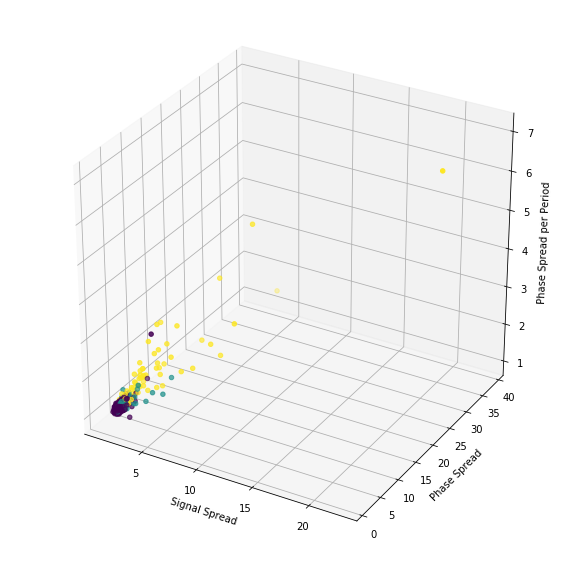

In [92]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D([r[1] for r in ratios], [r[3] for r in ratios], [r[2] for r in ratios], c=colors, cmap='viridis')
ax.set_xlabel('Signal Spread')
ax.set_ylabel('Phase Spread')
ax.set_zlabel('Phase Spread per Period')
plt.show()

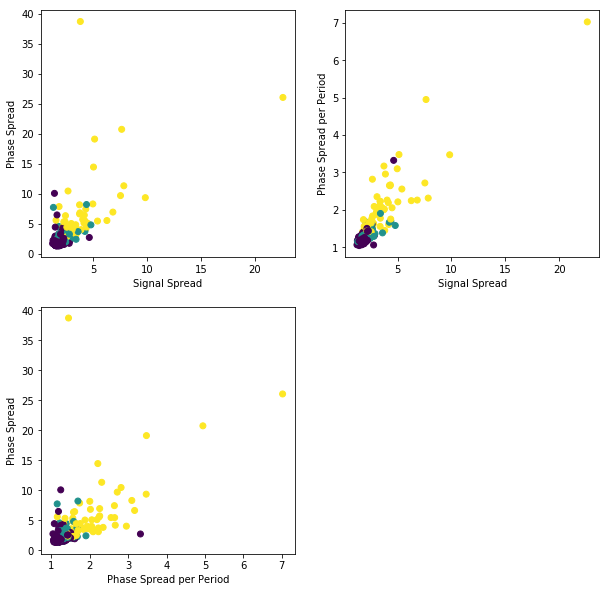

In [91]:
o, a, b, c = [r[0] for r in ratios], [r[1] for r in ratios], [r[3] for r in ratios], [r[2] for r in ratios]

colors = [good_objs_bak[ob] for ob in o]

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[1,1].axis('off')

axs[0,0].scatter(a, b, c=colors, cmap='viridis')
axs[0,0].set_xlabel('Signal Spread')
axs[0,0].set_ylabel('Phase Spread')

axs[1,0].scatter(c, b, c=colors, cmap='viridis')
axs[1,0].set_xlabel('Phase Spread per Period')
axs[1,0].set_ylabel('Phase Spread')

axs[0,1].scatter(a, c, c=colors, cmap='viridis')
axs[0,1].set_xlabel('Signal Spread')
axs[0,1].set_ylabel('Phase Spread per Period')

plt.show()

TypeError: 'int' object does not support item assignment

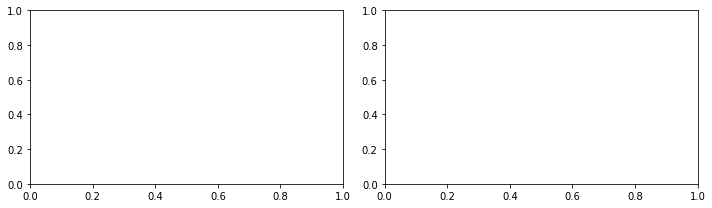

In [15]:
import ipywidgets as widgets
from IPython.display import display, clear_output
# good_objs = {}
objs = field.objects.keys()

buttony = widgets.Button(description="Good!")
buttonm = widgets.Button(description="Maybe?")
buttonn = widgets.Button(description="Bad!")
buttone = widgets.Button(description="Finish")

buttony.style.button_color = 'green'
buttonm.style.button_color = 'yellow'
buttonn.style.button_color = 'red'
buttone.style.button_color = 'gray'

bb = widgets.HBox([buttony, buttonn, buttonm, buttone])

button_press = None
def on_ybutton_clicked(b):
    button_press = 1.0
    next_plot(v=button_press)
#     clear_output()

def on_nbutton_clicked(b):
    button_press = 0.0
    next_plot(v=button_press)
#     clear_output()

def on_mbutton_clicked(b):
    button_press = 0.5
    next_plot(v=button_press)
#     clear_output()

def on_ebutton_clicked(b):
    next_plot(exit=True)
#     clear_output()

buttony.on_click(on_ybutton_clicked)
buttonm.on_click(on_mbutton_clicked)
buttonn.on_click(on_nbutton_clicked)
buttone.on_click(on_ebutton_clicked)

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

i = 0

def next_plot(v=None, first=False, exit=False):
    global button_press
    global i
    clear_output()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    fig.tight_layout()
    if not first:
        good_objs[objs[i-1]] = v
    try:
        obj = field[objs[i]]
    except IndexError:
        print 'nope'
        return
    else:
#         ax1.clear()
#         ax2.clear()
        print obj
        t = obj.timeseries_binned
        f = obj.flux_binned
        p = obj.periods[0]
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)

        ax1.scatter(t-t[0], f, s=0.1)
        ax1.set_title('Data'.format(p))
        ax2.scatter(phase_app, data_app, s=0.1)
        ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
        ax2.axvline(x=0, lw=0.1, c='k', ls='--')
        ax2.axvline(x=1, lw=0.1, c='k', ls='--')
        ax2.set_title('Data phase folded on {} day period'.format(p))
        plt.show()
        if exit:
            return
        else:
            display(bb)
            i += 1

next_plot(first=True)
# while i < field.num_objects:

{85: 1.0,
 102: 0.0,
 112: 0.0,
 118: 1.0,
 175: 0.0,
 192: 0.5,
 272: 0.0,
 291: 1.0,
 309: 0.0,
 337: 0.0,
 598: 0.0,
 624: 1.0,
 710: 0.0,
 714: 1.0,
 808: 0.0,
 862: 0.0,
 927: 0.5,
 950: 0.0,
 1020: 0.0,
 1045: 0.5,
 1105: 0.5,
 1185: 1.0,
 1388: 0.0,
 1405: 0.0,
 1447: 0.0,
 1490: 0.0,
 1593: 0.0,
 1615: 0.0,
 1697: 0.0,
 1709: 0.5,
 1724: 0.0,
 1762: 0.0,
 1931: 0.0,
 1959: 0.5,
 2091: 0.0,
 2098: 1.0,
 2160: 1.0,
 2311: 0.5,
 2447: 0.0,
 2550: 0.5,
 2604: 0.0,
 2630: 0.5,
 2683: 1.0,
 2734: 0.0,
 2744: 1.0,
 2880: 1.0,
 3188: 0.0,
 3228: 1.0,
 3335: 0.5,
 3346: 1.0,
 3476: 0.0,
 3490: 0.0,
 3577: 0.0,
 3664: 1.0,
 3699: 0.0,
 3702: 0.0,
 3747: 0.5,
 3765: 0.0,
 3788: 0.5,
 3842: 1.0,
 3872: 0.0,
 3944: 0.0,
 3962: 0.0,
 4216: 0.5,
 4241: 1.0,
 4248: 1.0,
 4294: 0.0,
 4315: 0.0,
 4327: 0.0,
 4329: 1.0,
 4333: 1.0,
 4373: 0.0,
 4389: 0.0,
 4475: 0.0,
 4559: 0.5,
 4628: 1.0,
 4683: 0.5,
 4728: 0.0,
 4803: 0.0,
 4843: 0.0,
 5210: 1.0,
 5214: 1.0,
 5220: 0.0,
 5241: 0.0,
 5293: 0.0,

In [83]:
from copy import deepcopy
good_objs_bak = deepcopy(good_objs)

In [87]:
good_objs_bak

{85: 1.0,
 102: 0.0,
 112: 0.0,
 118: 1.0,
 175: 0.0,
 192: 0.5,
 272: 0.0,
 291: 1.0,
 309: 0.0,
 337: 0.0,
 598: 0.0,
 624: 1.0,
 710: 0.0,
 714: 1.0,
 808: 0.0,
 862: 0.0,
 927: 0.5,
 950: 0.0,
 1020: 0.0,
 1045: 0.5,
 1105: 0.5,
 1185: 1.0,
 1388: 0.0,
 1405: 0.0,
 1447: 0.0,
 1490: 0.0,
 1593: 0.0,
 1615: 0.0,
 1697: 0.0,
 1709: 0.5,
 1724: 0.0,
 1762: 0.0,
 1931: 0.0,
 1959: 0.5,
 2091: 0.0,
 2098: 1.0,
 2160: 1.0,
 2311: 0.5,
 2447: 0.0,
 2550: 0.5,
 2604: 0.0,
 2630: 0.5,
 2683: 1.0,
 2734: 0.0,
 2744: 1.0,
 2880: 1.0,
 3188: 0.0,
 3228: 1.0,
 3335: 0.5,
 3346: 1.0,
 3476: 0.0,
 3490: 0.0,
 3577: 0.0,
 3664: 1.0,
 3699: 0.0,
 3702: 0.0,
 3747: 0.5,
 3765: 0.0,
 3788: 0.5,
 3842: 1.0,
 3872: 0.0,
 3944: 0.0,
 3962: 0.0,
 4216: 0.5,
 4241: 1.0,
 4248: 1.0,
 4294: 0.0,
 4315: 0.0,
 4327: 0.0,
 4329: 1.0,
 4333: 1.0,
 4373: 0.0,
 4389: 0.0,
 4475: 0.0,
 4559: 0.5,
 4628: 1.0,
 4683: 0.5,
 4728: 0.0,
 4803: 0.0,
 4843: 0.0,
 5210: 1.0,
 5214: 1.0,
 5220: 0.0,
 5241: 0.0,
 5293: 0.0,